In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [2]:
# Load the data
calendar_df = pd.read_csv('data/calendar_preprocessed.csv')
gps_data_df = pd.read_csv('data/gps_data_preprocessed.csv')
roster_df = pd.read_csv('data/roster_preprocessed.csv')
wellness_df = pd.read_csv('data/wellness_preprocessed.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Merge relevant dataframes (GPS data and Wellness data)
merged_df = pd.merge(gps_data_df, wellness_df, on=['Player Name', 'Session Date'], how='inner')

# Add a new column "High Speed Running" based on the sum of "Distance Zone 5" and "Distance Zone 6"
merged_df['High Speed Running'] = merged_df['Distance Zone 5'] + merged_df['Distance Zone 6']

# Adjust thresholds (this is unchanged from your original code)
low_energy_threshold = 3 
high_soreness_threshold = 8
high_stress_threshold = 8 
high_speed_running_threshold = 40  

# Add a "high_risk" label based on multiple conditions
merged_df['high_risk'] = (
    (merged_df['Energy'] < low_energy_threshold) |
    (merged_df['Soreness'] > high_soreness_threshold) |
    (merged_df['Stress'] > high_stress_threshold) |
    (merged_df['High Speed Running'] > high_speed_running_threshold)
).astype(int)

# Feature Scaling to change the importance of the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(merged_df[['Total Distance', 'Metres Per Minute', 'High Speed Running',
                                                  'Energy', 'Soreness', 'Stress']])

# Modify the importance of specific features
scaled_features[:, 3] = scaled_features[:, 3] * 1.50  # Increase 'Energy' importance by 25%
scaled_features[:, 4] = scaled_features[:, 4] * 0.50  # Decrease 'Soreness' importance by 25%
scaled_features[:, 4] = scaled_features[:, 5] * 0.50  # Decrease 'Stress' importance by 25%


# Select relevant features for training the model
features = scaled_features

# Set the target variable: 'high_risk' (1 = high injury risk, 0 = low risk)
target = merged_df['high_risk']

# Display the updated dataframe
merged_df.head()

,Player Name,Session Date,Drill Name,Session Time(mins),Total Distance,Metres Per Minute,Distance Zone 1,Distance Zone 2,Distance Zone 3,Distance Zone 4,...,Step Balance,HML Efforts,Explosive Distance,Energy,Sleep Quality,Stress,Soreness,Total Score,High Speed Running,high_risk
0,Vinicius Jr,2022-09-01,Crossing & Finishing,29.45,2052.0,69.66,577.0,680.0,561.0,231.0,...,0.86,26.0,179,10,10,10,9,39,3.0,1
1,Mariano,2022-09-01,Crossing & Finishing,29.45,1395.0,47.36,666.0,461.0,152.0,104.0,...,0.74,22.0,162,9,8,7,8,32,11.0,0
2,Camavinga,2022-09-15,Crossing & Finishing,30.40,1576.0,51.85,831.0,344.0,171.0,148.0,...,1.15,40.0,213,9,9,9,8,35,82.0,1
3,Ceballos,2022-09-15,Crossing & Finishing,4.61,141.0,30.56,76.0,41.0,11.0,12.0,...,0.06,2.0,15,7,6,9,9,31,0.0,1
4,Carvajal,2022-09-15,Crossing & Finishing,30.40,1370.0,45.05,630.0,379.0,174.0,167.0,...,0.80,21.0,180,8,8,8,8,32,19.0,0


In [4]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display the sizes of the train and test sets
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 170 samples
Test set size: 43 samples


In [5]:
from imblearn.over_sampling import SMOTE

X_train_filled = pd.DataFrame(X_train).fillna(pd.DataFrame(X_train).median())
X_test_filled = pd.DataFrame(X_test).fillna(pd.DataFrame(X_test).median())

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_filled)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score


lr = LogisticRegression(max_iter=1000, class_weight='balanced')  # max_iter is set to 1000 to ensure convergence
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = lr.predict(X_test_scaled)

# Evaluate the model using ROC AUC score (or other metrics like accuracy, confusion matrix)
roc_auc = roc_auc_score(y_test, y_pred)

In [7]:
# Evaluate the model's performance using accuracy, precision, recall, F1 score, and ROC AUC
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")


Accuracy: 0.86
Precision: 0.91
Recall: 0.84
F1 Score: 0.88
ROC AUC: 0.86


[[16  2]
 [ 4 21]]


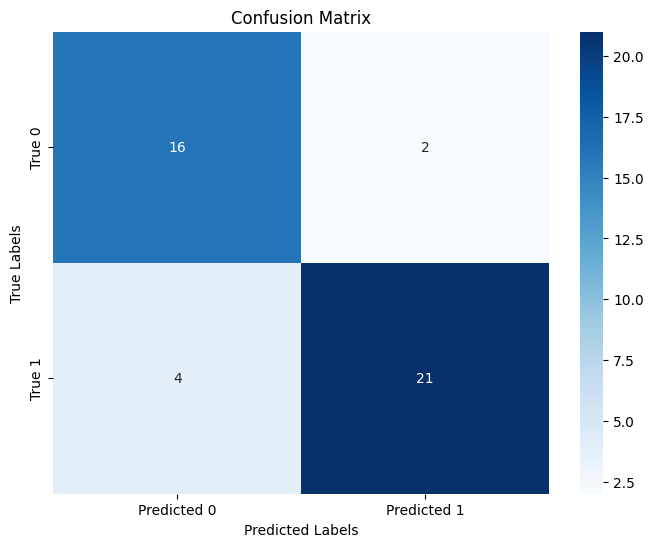

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print(cm)


# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [9]:
import pickle

with open('injury_risk_model.pkl', 'wb') as model_file:
    pickle.dump(lr, model_file)  # Use rf instead of rf_model